# Assess the Poisson estimator

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [188]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util

In [19]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

### Check 1D estimates of `sceb` with `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [20]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(100, 20))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [21]:
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors)
var_scdd = scdd.M_to_var(M_dd)
print(var_scdd)

#time start: 0.0s
n_cell=100, n_gene=20
#total: 0.00s
[4.05811359e+00 8.65557033e+01 3.38042239e+00 8.67055877e+01
 5.87806859e-02 3.99841925e+01 8.48237731e+00 1.28562336e+01
 4.02345703e+00 2.43614751e+00 9.80252612e-02 1.62111844e+01
 1.05115668e+01 9.53143947e-01 1.36284024e+02 2.32362990e+01
 8.75613957e-01 9.43882965e+01 6.77484907e+01 5.34462511e-01]


In [22]:
imp.reload(estimator)
mean_scmemo, var_scmemo = estimator._poisson_1d(data, data.shape[0], size_factors)
print(var_scmemo)

[4.05811419e+00 8.65558825e+01 3.38042193e+00 8.67056078e+01
 5.87806855e-02 3.99841965e+01 8.48237715e+00 1.28562306e+01
 4.02345666e+00 2.43614724e+00 9.80252592e-02 1.62111701e+01
 1.05115720e+01 9.53144150e-01 1.36289603e+02 2.32362900e+01
 8.75614006e-01 9.43883035e+01 6.77483004e+01 5.34462544e-01]


In [23]:
df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr'] = data[:, 0].todense().A1
precomputed_size_factors = df.groupby('expr')['inv_size_factor'].mean(), df.groupby('expr')['inv_size_factor_sq'].mean()

In [24]:
imp.reload(estimator)
expr, count = np.unique(data[:, 0].todense().A1, return_counts=True)
print(estimator._poisson_1d((expr, count), data.shape[0], precomputed_size_factors))

[0.9063726711273193, 4.058114381881536]


### Check 2D estimates of `sceb` and `scmemo`

Using the Poisson model. The outputs should be identical, this is for checking the implementation. 

In [25]:
data = sp.sparse.csr_matrix(simulate.simulate_transcriptomes(1000, 4))
adata = sc.AnnData(data)
size_factors = scdd.dd_size_factor(adata)

In [26]:
mean_scdd, cov_scdd, corr_scdd = scdd.dd_covariance(adata, size_factors)
print(cov_scdd)

[[ 4.09247186e-01 -7.00641019e-03  1.11981475e-02 -5.42475049e-01]
 [-7.00641019e-03  3.07633212e-01 -6.79097739e-03 -3.44895561e-01]
 [ 1.11981475e-02 -6.79097739e-03  5.31315636e-01 -6.31933899e-01]
 [-5.42475049e-01 -3.44895561e-01 -6.31933899e-01  1.00000000e-12]]


In [27]:
imp.reload(estimator)
cov_scmemo = estimator._poisson_cov(data, data.shape[0], size_factors, idx1=[0, 1, 2], idx2=[1, 2, 3])
print(cov_scmemo)

[[-0.00700641  0.01119815 -0.54247505]
 [ 0.30763321 -0.00679098 -0.34489556]
 [-0.00679098  0.53131564 -0.6319339 ]]


In [28]:
expr, count = np.unique(data[:, :2].toarray(), return_counts=True, axis=0)

df = pd.DataFrame()
df['size_factor'] = size_factors
df['inv_size_factor'] = 1/size_factors
df['inv_size_factor_sq'] = 1/size_factors**2
df['expr1'] = data[:, 0].todense().A1
df['expr2'] = data[:, 1].todense().A1

precomputed_size_factors = df.groupby(['expr1', 'expr2'])['inv_size_factor'].mean(), df.groupby(['expr1', 'expr2'])['inv_size_factor_sq'].mean()

In [30]:
cov_scmemo = estimator._poisson_cov((expr[:, 0], expr[:, 1], count), data.shape[0], size_factor=precomputed_size_factors)
print(cov_scmemo)

-0.007006410053126586


### Variance/correlation estimation while varying q_sq

In [34]:
q = 0.1
q_sq_list = [0.011]#[0.1**2+1e-6, 0.0102, 0.0106, 0.012]

In [35]:
import warnings
warnings.filterwarnings("ignore")


In [67]:
plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=1.1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 3

for col_num, q_sq in enumerate(q_sq_list):
    
    true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=True)
    qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))

    
    x_true, y_true = np.log(true_data.mean(axis=0)), np.log(true_data.var(axis=0))
    x_obs, y_obs = np.log(captured_data.mean(axis=0)), np.log(captured_data.var(axis=0))
    
    _, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False)
    var_scdd = scdd.M_to_var(M_dd)/q**2
    
    mean_scdd, _, corr_scdd = scdd.dd_covariance(adata, size_factor=scdd.dd_size_factor(adata))
    corr_scdd[corr_scdd == 0] = np.nan
    
    condition = np.log(var_scdd) > -20
    
    true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
    estimated_corrs = corr_scdd.ravel()
    corr_cond = np.isfinite(estimated_corrs)
    true_corrs = true_corrs[corr_cond]
    estimated_corrs = estimated_corrs[corr_cond]
    
    break
    
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1)
    sns.distplot(qs)
    plt.xlabel('q, Var(q)={:.1e}'.format(q_sq-q**2))
    plt.xlim(0, 0.5)
    if col_num == 0:
        plt.ylabel('Density')
        
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1+num_subplot_col)
    plt.plot(y_true, y_true, color='m', lw=1)
    plt.scatter(y_true[condition], np.log(var_scdd)[condition], s=1)
    plt.xlabel('True variance');
    if col_num == 0:
        plt.ylabel('Estimated\nvariance')
    plt.title('R={:.3f}'.format(stats.pearsonr(np.log(var_scdd)[condition], y_true[condition])[0]))
    
    sample_idxs = np.random.choice(estimated_corrs.shape[0], 5000, replace=False)
    plt.subplot(num_subplot_row, num_subplot_col, col_num+1+num_subplot_col*2)
    plt.plot(true_corrs, true_corrs, color='m', lw=1)
    plt.scatter(true_corrs, estimated_corrs, s=.01, alpha=0.01)
    plt.xlabel('True correlation');
    if col_num == 0:
        plt.ylabel('Estimated\ncorrelation')
    plt.title('R={:.3f}'.format(stats.pearsonr(true_corrs, estimated_corrs)[0]))
    

<Figure size 504x360 with 0 Axes>

### Approximate bootstrap

In [321]:
true_data = simulate.simulate_transcriptomes(10000, 5000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = 'PBMC'

In [420]:
size_factors = scdd.dd_size_factor(adata)
Nr = adata.X.sum(axis=1).mean()
_, M_dd = scdd.dd_1d_moment(adata, size_factor=size_factors, verbose=False, Nr=Nr)
var_scdd = scdd.M_to_var(M_dd)
num_boot = 100000


In [421]:
estimator._poisson_1d(sp.sparse.csc_matrix(data_first_gene), adata.shape[0], size_factor=size_factors, n_umi=Nr)

[array([8.046989e-07], dtype=float32), array([1.0446381e-10], dtype=float32)]

In [422]:
boot_idxs

array([6924, 6913, 8122, ..., 3721, 4146, 2402])

In [423]:
%%time
#Real bootstrap
real_boot_vars = []
data_first_gene = adata.X[:, [0]].toarray()
for trial in range(num_boot):
    
    boot_idxs = np.random.choice(adata.shape[0], adata.shape[0], replace=True)
    mean, var = estimator._poisson_1d(sp.sparse.csc_matrix(data_first_gene[boot_idxs]), adata.shape[0], size_factor=size_factors[boot_idxs], n_umi=Nr)
    
    real_boot_vars.append(var[0])

CPU times: user 1min 11s, sys: 25.4 ms, total: 1min 11s
Wall time: 1min 11s


In [424]:
var_scdd

array([1.04463809e-10, 4.64152648e-09, 6.46394305e-11, ...,
       6.24598617e-10, 1.63493020e-11, 1.45414815e-10])

In [425]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct'], inplace=True)
scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=False, residual_var=True)

In [426]:
adata_scmemo.uns['scmemo']['1d_moments']['sg^PBMC'][1]

array([1.04463801e-10, 4.64148457e-09, 6.46394857e-11, ...,
       6.24596062e-10, 1.63492853e-11, 1.45414867e-10])

In [491]:
%%time
# res_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=1)
# res_2 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=2)
res_3 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=3)


sg^PBMC
CPU times: user 127 ms, sys: 60 ms, total: 186 ms
Wall time: 186 ms


In [463]:
from statsmodels.distributions.empirical_distribution import ECDF

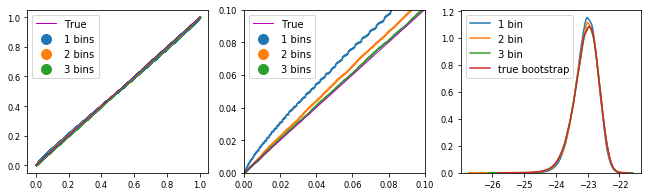

In [489]:
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 2)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.xlim(0, .1); plt.ylim(0, .1)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 3)
sns.distplot(np.log(res_1[1]), hist=False, label='1 bin')
sns.distplot(np.log(res_2[1]), hist=False, label='2 bin')
sns.distplot(np.log(res_3[1]), hist=False, label='3 bin')
sns.distplot(np.log(real_boot_vars), hist=False, label='true bootstrap')


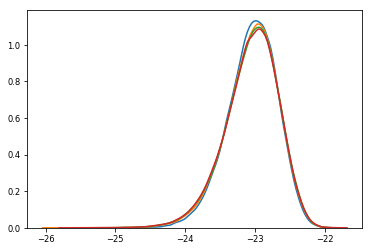

In [444]:
sns.distplot(np.log(res_1[1]), hist=False)
sns.distplot(np.log(res_2[1]), hist=False)
sns.distplot(np.log(res_3[1]), hist=False)
sns.distplot(np.log(real_boot_vars), hist=False)


In [305]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

<module 'util' from '/home/ssm-user/Github/scrna-parameter-estimation/scmemo/util.py'>

In [307]:
bin_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=5).uns['scmemo']['1d_ci']['sg^PBMC'][1]
bin_5 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=5).uns['scmemo']['1d_ci']['sg^PBMC'][1]
bin_10 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=5).uns['scmemo']['1d_ci']['sg^PBMC'][1]
bin_20 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=5).uns['scmemo']['1d_ci']['sg^PBMC'][1]

sg^PBMC
sg^PBMC
sg^PBMC
sg^PBMC


In [313]:
def robust_corr(x, y):
    
    cond = np.isfinite(x) & np.isfinite(y)
    return stats.pearsonr(x[cond], y[cond])

In [320]:
print(robust_corr(np.log(real_boot_vars_ci), np.log(bin_1)))
print(robust_corr(np.log(real_boot_vars_ci), np.log(bin_10)))
print(robust_corr(np.log(real_boot_vars_ci), np.log(bin_20)))

(0.9996703908594072, 1.6587523800084748e-154)
(0.9997227890073601, 4.085480534812658e-158)
(0.9996890604128181, 1.0103067057701995e-155)


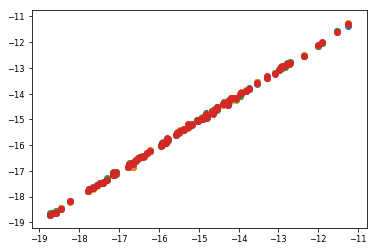

In [311]:
plt.scatter(
    np.log(real_boot_vars_ci),
    np.log(bin_1)
)
plt.scatter(
    np.log(real_boot_vars_ci),
    np.log(bin_5)
)
plt.scatter(
    np.log(real_boot_vars_ci),
    np.log(bin_10)
)
plt.scatter(
    np.log(real_boot_vars_ci),
    np.log(bin_20)
)

In [175]:
import string

In [178]:
df = pd.DataFrame()
df['size_factor'] = size_factors
df['expr'] = expr
df['bin'] = df.groupby('expr')['size_factor'].transform(lambda x: pd.cut(x, bins=5, labels=list(string.ascii_lowercase[:5])))
df['inv_size_factor'] = df.groupby(['expr', 'bin'])['size_factor'].transform(lambda x: (1/x).mean())
df['inv_size_factor_sq'] = df.groupby(['expr', 'bin'])['size_factor'].transform(lambda x: (1/x**2).mean())

In [165]:
def _sparse_bincount(data, size_factor):
	""" Sparse bincount. """
	
	y = data.dot(np.random.random(data.shape[1])) + np.random.random()*size_factor
	_, index, counts = np.unique(y, return_counts=True, return_index=True)
	
	return data[index].toarray(), counts, size_factor[index]

In [179]:
_sparse_bincount(data[:, 0], df['inv_size_factor'].values)[0].shape

(89, 1)

In [182]:
data[[1, 2, 3], 0].toarray()[[1, 2]]

array([[0.],
       [0.]], dtype=float32)

In [169]:
data[:, 0].shape

(5000, 1)

In [164]:
np.random.random()

0.5389121891362616

In [150]:
data[:, 0].dot(-3).shape

(5000, 1)

In [156]:
%%time
data[:, [0]].dot([0.3])#+(np.ones((adata.shape[0], 1)))

CPU times: user 576 µs, sys: 53 µs, total: 629 µs
Wall time: 464 µs


array([0., 0., 0., ..., 0., 0., 0.])

In [157]:
data[:, [0]]

<5000x1 sparse matrix of type '<class 'numpy.float32'>'
	with 21 stored elements in Compressed Sparse Column format>

In [163]:
data[:, 0].dot(np.random.random(1))

array([0., 0., 0., ..., 0., 0., 0.])

In [139]:
data = adata.X.tocsc()

In [144]:
%%time
a = np.hstack([data[:, 0].toarray(), np.ones((adata.shape[0], 1))])

CPU times: user 1.23 ms, sys: 113 µs, total: 1.34 ms
Wall time: 790 µs


In [145]:
%%time
sp.sparse.hstack([data[:, 0], np.ones((adata.shape[0], 1))])

CPU times: user 1.76 ms, sys: 160 µs, total: 1.92 ms
Wall time: 1.13 ms


<5000x2 sparse matrix of type '<class 'numpy.float64'>'
	with 5021 stored elements in COOrdinate format>

In [130]:
adata.X

<5000x1000 sparse matrix of type '<class 'numpy.float32'>'
	with 1545119 stored elements in Compressed Sparse Row format>

In [129]:
df = pd.DataFrame()
df['size_factor'] = size_factor
df['expr'] = expr
df['bin'] = df.groupby('expr')['size_factor'].transform(lambda x: pd.cut(x, bins=bins, labels=list(string.ascii_lowercase[:bins])))
df['inv_size_factor'] = df.groupby(['expr', 'bin'])['size_factor'].transform(lambda x: (1/x).mean())
df['inv_size_factor_sq'] = df.groupby(['expr', 'bin'])['size_factor'].transform(lambda x: (1/x**2).mean())

In [117]:
df.groupby(['expr', 'bin'])['size_factor'].transform(lambda x: )

1       0.558796
7       0.559218
8       0.520783
17      0.567666
43      0.575268
73      0.567666
75      0.597232
76      0.620040
93      0.601455
120     0.555839
136     0.255112
146     0.608213
152     0.532187
178     0.530497
221     0.449824
238     0.412233
242     0.482769
301     0.617083
320     0.580337
332     0.620462
340     0.640736
350     0.549081
354     0.430818
404     0.558374
428     0.590474
440     0.538944
469     0.540212
477     0.534298
503     0.609480
504     0.534298
507     0.248776
521     0.455315
526     0.506844
528     0.305796
557     0.485726
579     0.613282
611     0.613282
614     0.452781
637     0.500509
642     0.242441
686     0.620040
695     0.595964
696     0.641158
708     0.629332
714     0.610325
721     0.454048
725     0.625530
734     0.539789
754     0.576535
756     0.459539
810     0.629754
816     0.627642
833     0.534298
841     0.290168
842     0.494596
853     0.417302
859     0.583293
861     0.497552
871     0.6196

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
4995   NaN
4996   NaN
4997   NaN
4998   NaN
4999   NaN
Name: size_factor, Length: 5000, dtype: float32

In [100]:
df = pd.DataFrame()
df['size_factor'] = size_factors
df['expr'] = one_gene_data
df['bin'] = df.groupby('expr')['size_factor'].transform(lambda x: pd.cut(x, bins=1))
df['inv_size_factor'] = df.groupby(['expr', 'bin'])['size_factor'].transform(lambda x: (1/x).mean())
df['inv_cell_size_sq'] = 1/(size_factors**2)

TypeError: Cannot convert IntervalArray to numpy.ndarray

In [98]:
df.head(5)

,cell_size,cell_size_sq,inv_cell_size,inv_cell_size_sq,expr,binned_size_factors
0,1.518421,2.305603,0.658579,0.433726,0,"(0.195, 2.43]"
1,0.558796,0.312253,1.789562,3.202533,0,"(0.195, 2.43]"
2,1.001862,1.003728,0.998141,0.996286,0,"(0.195, 2.43]"
3,1.201643,1.443947,0.832194,0.692546,7,"(0.491, 2.062]"
4,1.480830,2.192858,0.675297,0.456026,1,"(0.284, 2.045]"


In [92]:
def f(x):
    return pd.cut(x, bins=5)

In [95]:
df['binned_size_factors'] = df.groupby('expr')['cell_size'].transform(lambda x: pd.cut(x, bins=1))

In [73]:
df.groupby('expr').transform(lambda x: pd.qcut(x, q=5, duplicates='drop'))

IndexError: ('index 0 is out of bounds for axis 0 with size 0', 'occurred at index cell_size')

In [51]:
expr, count = np.unique(one_gene_data, return_counts=True)
freq = count/count.sum()
multi_rvs = stats.multinomial.rvs(one_gene_data.shape[0], freq, size=num_boot)

In [64]:
np.unique(size_factors).shape

(38,)

In [65]:
size_factors.shape

(5000,)

In [53]:
approx_boot_vars = (expr**2*multi_rvs*df.groupby('expr')['inv_cell_size_sq'].mean().values).sum(axis=1)/count.sum() - \
    (expr*multi_rvs*df.groupby('expr')['inv_cell_size_sq'].mean().values).sum(axis=1)/count.sum()

In [57]:
var_scdd[1]

57.560252590527824

In [55]:
real_boot_vars.mean()

1.4645539796588014

In [56]:
approx_boot_vars.mean()

1.4643878515713078

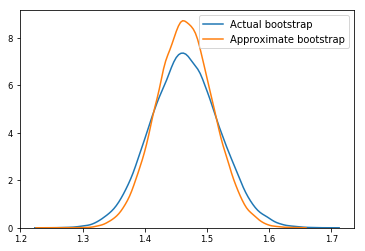

In [54]:
sns.distplot(real_boot_vars, label='Actual bootstrap', hist=False)
sns.distplot(approx_boot_vars, label='Approximate bootstrap', hist=False)
plt.legend()

In [600]:
df = pd.DataFrame()
df['cell_size'] = size_factors
df['cell_size_sq'] = size_factors**2
df['inv_cell_size'] = 1/size_factors
df['inv_cell_size_sq'] = 1/(size_factors**2)
df['expr'] = one_gene_data

In [601]:
inv_cell_sizes = df.groupby('expr')['inv_cell_size'].mean().values
cell_sizes = df.groupby('expr')['cell_size'].mean().values

In [602]:
expr, count = np.unique(one_gene_data, return_counts=True)
freq = count/count.sum()
multi_rvs = stats.multinomial.rvs(one_gene_data.shape[0], freq, size=1000)

In [578]:
(expr**2*count).sum()/count.sum()

4.1872

In [554]:
multi_rvs.shape

(1000, 14)

In [539]:
#approx bootstrap
approx_boot_vars = []
expr, count = np.unique(one_gene_data, return_counts=True)


for trial in range(1):
    
    boot_idxs = np.random.choice(one_gene_data.shape[0], one_gene_data.shape[0])
    expr = one_gene_data[boot_idxs]
    second = ((one_gene_data[boot_idxs]/size_factors[boot_idxs])**2).mean()-(one_gene_data[boot_idxs]/size_factors[boot_idxs]**2).mean()
    first = (one_gene_data[boot_idxs]/size_factors[boot_idxs]).mean()
    
    approx_boot_vars.append( (second-first**2)/q**2 )
approx_boot_vars = np.array(real_boot_vars)

# HAHHAHAHA

In [ ]:
plt.figure(figsize=(7, 5))
plt.subplots_adjust(hspace=1.1, wspace=0.3)
num_subplot_col = len(q_sq_list)
num_subplot_row = 3

q_sq = 0.011
true_data = simulate.simulate_transcriptomes(5000, 1000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q, q_sq)
adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))


x_true, y_true = np.log(true_data.mean(axis=0)), np.log(true_data.var(axis=0))
x_obs, y_obs = np.log(captured_data.mean(axis=0)), np.log(captured_data.var(axis=0))

_, M_dd = scdd.dd_1d_moment(adata, size_factor=scdd.dd_size_factor(adata), verbose=False)
var_scdd = scdd.M_to_var(M_dd)/q**2

mean_scdd, _, corr_scdd = scdd.dd_covariance(adata, size_factor=None)
corr_scdd[corr_scdd == 0] = np.nan

true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
estimated_corrs = corr_scdd.ravel()
corr_cond = np.isfinite(estimated_corrs)
true_corrs = true_corrs[corr_cond]
estimated_corrs = estimated_corrs[corr_cond]
    
condition = np.log(var_scdd) > -20

In [654]:
means = np.log(np.outer(mean_scdd, mean_scdd).ravel())
estimated_corrs = corr_scdd.ravel()
raw_corrs = np.corrcoef(captured_data, rowvar=False).ravel()
true_corrs = np.corrcoef(true_data, rowvar=False).ravel()
norm_captured_data = captured_data / captured_data.sum(axis=1).reshape(-1, 1)
norm_corrs = np.corrcoef(norm_captured_data, rowvar=False).ravel()
norm_means = np.log(np.outer(norm_captured_data.mean(axis=0),norm_captured_data.mean(axis=0))).ravel()

In [655]:
sample_idxs = np.random.choice(means.shape[0], 10000)

(0.6290164568787581, 0.0)

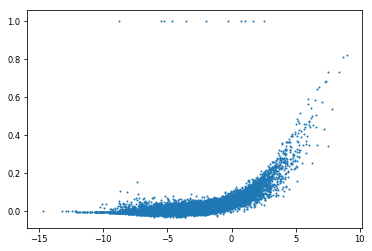

In [656]:
plt.scatter(means[sample_idxs], raw_corrs[sample_idxs], s=1)
condition = np.isfinite(raw_corrs[sample_idxs])
stats.pearsonr(means[sample_idxs][condition], raw_corrs[sample_idxs][condition])

(-0.008869409665721239, 0.375686925836576)

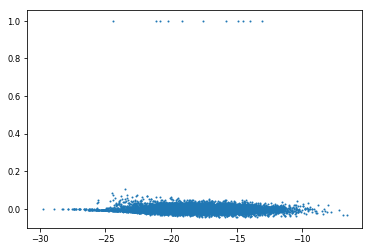

In [657]:
plt.scatter(norm_means[sample_idxs], norm_corrs[sample_idxs], s=1)
condition = np.isfinite(norm_corrs[sample_idxs])
stats.pearsonr(norm_means[sample_idxs][condition], norm_corrs[sample_idxs][condition])

Text(0, 0.5, 'estimated correlation')

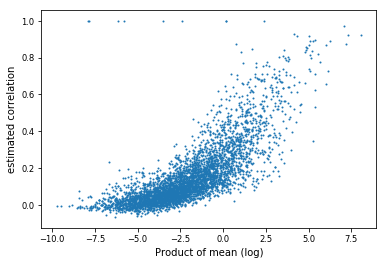

In [480]:
plt.scatter(means[sample_idxs], estimated_corrs[sample_idxs], s=1)
condition = np.isfinite(estimated_corrs[sample_idxs]) & np.isfinite(means[sample_idxs])
stats.pearsonr(means[sample_idxs][condition], estimated_corrs[sample_idxs][condition])
# plt.ylim(-0.25, 0.25)
plt.xlabel('Product of mean (log)');plt.ylabel('estimated correlation')